# Import Dependencies

In [79]:
# DATA MANIPULTION
import pandas as pd
import numpy as np
import re

# DATA VIZ
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# STATS
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

# MACHINE LEARNING
## PREPROCESSING
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
## MODEL SELECTION
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
## SCALERS
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
## CLASSIFICATION MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
## EVALUATION
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
## MODEL TUNING
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Dataset

In [2]:
#set max columns display
pd.options.display.max_columns = 50

df = pd.read_excel('8WS2_ver2.xlsx')
df.head()

,従業員番号,離職,年齢,部署,役職,職位,性別,配偶者状況,業績評価,勤続年数,学歴,修学分野,業務経験年数,前年度研修参加回数,現職位経験年数,前回昇進からの経過年数,現管理者との業務年数,転職回数,出張頻度,通勤距離(km),ワークライフバランス,環境満足度,業務関与度,業務満足度,関係性満足度,標準業務時間,月収,給与上昇率,ストックオプションレベル,月勤務時間,残業時間,有給長期休暇利用開始日,有給長期休暇利用終了日
0,1,Yes,41,Sales,Sales Executive,2,Female,Single,3,6,2,Life Sciences,8,0,4,0,5,8,Travel_Rarely,1,1,2,3,4,1,8,5993,11,0,147,OverTimePay: 38,2015年10月16日,2015年10月17日
1,2,No,49,Research & Development,Research Scientist,2,Male,Married,4,10,1,Life Sciences,10,3,7,1,7,1,Travel_Frequently,8,3,3,2,2,4,8,5130,23,1,176,OverTimePay: 2,2015年6月28日,2015年7月2日
2,4,Yes,37,Research & Development,Laboratory Technician,1,Male,Single,3,0,2,Other,7,3,0,0,0,6,Travel_Rarely,2,3,4,2,3,2,8,2090,15,0,259,OverTimePay: 4,2015年5月24日,2015年5月24日
3,5,No,33,Research & Development,Research Scientist,1,Female,Married,3,8,4,Life Sciences,8,3,7,3,0,1,Travel_Frequently,3,3,4,3,3,3,8,2909,11,0,229,OverTimePay: 22,2015年12月12日,2015年12月13日
4,7,No,27,Research & Development,Laboratory Technician,1,Male,Married,3,2,1,Medical,6,3,2,2,2,9,Travel_Rarely,2,3,1,3,2,4,8,3468,12,1,168,OverTimePay: 0,2015年8月21日,2015年8月24日


In [3]:
column_mapping = {
    '従業員番号': 'Employee ID',
    '離職': 'Resignation',
    '年齢': 'Age',
    '部署': 'Department',
    '役職': 'Position',
    '職位': 'Position Rank',
    '性別': 'Gender',
    '配偶者状況': 'Marital Status',
    '業績評価': 'Performance Rating',
    '勤続年数': 'Years of Service',
    '学歴': 'Education',
    '修学分野': 'Field of Study',
    '業務経験年数': 'Years of Experience',
    '前年度研修参加回数': 'Training Participation Last Year',
    '現職位経験年数': 'Years in Current Position',
    '前回昇進からの経過年数': 'Years Since Last Promotion',
    '現管理者との業務年数': 'Years with Current Manager',
    '転職回数': 'Number of Job Changes',
    '出張頻度': 'Business Travel Frequency',
    '通勤距離(km)': 'Commute Distance (km)',
    'ワークライフバランス': 'Work-Life Balance',
    '環境満足度': 'Job Environment Satisfaction',
    '業務関与度': 'Job Involvement',
    '業務満足度': 'Job Satisfaction',
    '関係性満足度': 'Relationship Satisfaction',
    '標準業務時間': 'Standard Hours',
    '月収': 'Monthly Income',
    '給与上昇率': 'Salary Hike Rate',
    'ストックオプションレベル': 'Stock Option Level',
    '月勤務時間': 'Monthly Working Hours',
    '残業時間': 'Overtime Hours',
    '有給長期休暇利用開始日': 'Paid Long Vacation Start Date',
    '有給長期休暇利用終了日': 'Paid Long Vacation End Date'
}

df = df.rename(columns=column_mapping)
df.columns

Index(['Employee ID', 'Resignation', 'Age', 'Department', 'Position',
       'Position Rank', 'Gender', 'Marital Status', 'Performance Rating',
       'Years of Service', 'Education', 'Field of Study',
       'Years of Experience', 'Training Participation Last Year',
       'Years in Current Position', 'Years Since Last Promotion',
       'Years with Current Manager', 'Number of Job Changes',
       'Business Travel Frequency', 'Commute Distance (km)',
       'Work-Life Balance', 'Job Environment Satisfaction', 'Job Involvement',
       'Job Satisfaction', 'Relationship Satisfaction', 'Standard Hours',
       'Monthly Income', 'Salary Hike Rate', 'Stock Option Level',
       'Monthly Working Hours', 'Overtime Hours',
       'Paid Long Vacation Start Date', 'Paid Long Vacation End Date'],
      dtype='object')

# Data Preprocessing
## Create functions to clean, process, and engineer features

In [4]:
## Translate column names from Japanese to English
def translate(df):
    column_mapping = {
    '従業員番号': 'Employee ID',
    '離職': 'Resignation',
    '年齢': 'Age',
    '部署': 'Department',
    '役職': 'Position',
    '職位': 'Position Rank',
    '性別': 'Gender',
    '配偶者状況': 'Marital Status',
    '業績評価': 'Performance Rating',
    '勤続年数': 'Years of Service',
    '学歴': 'Education',
    '修学分野': 'Field of Study',
    '業務経験年数': 'Years of Experience',
    '前年度研修参加回数': 'Training Participation Last Year',
    '現職位経験年数': 'Years in Current Position',
    '前回昇進からの経過年数': 'Years Since Last Promotion',
    '現管理者との業務年数': 'Years with Current Manager',
    '転職回数': 'Number of Job Changes',
    '出張頻度': 'Business Travel Frequency',
    '通勤距離(km)': 'Commute Distance (km)',
    'ワークライフバランス': 'Work-Life Balance',
    '環境満足度': 'Job Environment Satisfaction',
    '業務関与度': 'Job Involvement',
    '業務満足度': 'Job Satisfaction',
    '関係性満足度': 'Relationship Satisfaction',
    '標準業務時間': 'Standard Hours',
    '月収': 'Monthly Income',
    '給与上昇率': 'Salary Hike Rate',
    'ストックオプションレベル': 'Stock Option Level',
    '月勤務時間': 'Monthly Working Hours',
    '残業時間': 'Overtime Hours',
    '有給長期休暇利用開始日': 'Paid Long Vacation Start Date',
    '有給長期休暇利用終了日': 'Paid Long Vacation End Date'
    }

    df = df.rename(columns=column_mapping)
    return df

In [13]:
print(f"Total Number of Null values = {df.isnull().sum().sum()}")
print(f"Total Number of Duplicates = {df.duplicated().sum()}")

Total Number of Null values = 0
Total Number of Duplicates = 0


In [37]:
def get_features(df):
    df = translate(df)
    
    # encode categorical features
    df['Resignation'] = df['Resignation'].apply(lambda x: 0 if x == 'No' else 1)
    df['Age Group'] = df['Age'].apply(lambda x: int(x) // 10)
    df['Years to Retirement'] = df['Age'].apply(lambda x: 60 - x)
    df['Tenure'] = df['Years of Service'].apply(lambda x: 0 if x < 1 else (1 if x < 5 else 2))
    df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Female' else 1)
    df['Business Travel Frequency'] = df['Business Travel Frequency'].apply(lambda x: 0 if x =='Non-Travel' else (1 if x == 'Travel_Rarely' else 2))
    df['Overtime Hours'] = df['Overtime Hours'].apply(lambda x: re.sub(r'\D', '', str(x))).astype('int')
    df['Marital Status'] = df['Marital Status'].apply(lambda x: 0 if x =='Single' else (1 if x == 'Divorced' else 2))
    
    # engineer feature for length of long vacation taken
    df['Paid Long Vacation Start Date'] = pd.to_datetime(df['Paid Long Vacation Start Date'], format='%Y年%m月%d日')
    df['Paid Long Vacation End Date'] = pd.to_datetime(df['Paid Long Vacation End Date'], format='%Y年%m月%d日')
    df['Long Vacation'] = (df['Paid Long Vacation End Date'] - df['Paid Long Vacation Start Date']).dt.days
    
    #drop unnecessary columns
    df = df.drop(columns=['Employee ID', 'Field of Study', 'Paid Long Vacation Start Date', 'Paid Long Vacation End Date'])
    return df

In [38]:
feat_df = get_features(df)
feat_df.head()

,Resignation,Age,Department,Position,Position Rank,Gender,Marital Status,Performance Rating,Years of Service,Education,Years of Experience,Training Participation Last Year,Years in Current Position,Years Since Last Promotion,Years with Current Manager,Number of Job Changes,Business Travel Frequency,Commute Distance (km),Work-Life Balance,Job Environment Satisfaction,Job Involvement,Job Satisfaction,Relationship Satisfaction,Standard Hours,Monthly Income,Salary Hike Rate,Stock Option Level,Monthly Working Hours,Overtime Hours,Age Group,Years to Retirement,Tenure,Long Vacation
0,1,41,Sales,Sales Executive,2,0,0,3,6,2,8,0,4,0,5,8,1,1,1,2,3,4,1,8,5993,11,0,147,38,4,19,2,1
1,0,49,Research & Development,Research Scientist,2,1,2,4,10,1,10,3,7,1,7,1,2,8,3,3,2,2,4,8,5130,23,1,176,2,4,11,2,4
2,1,37,Research & Development,Laboratory Technician,1,1,0,3,0,2,7,3,0,0,0,6,1,2,3,4,2,3,2,8,2090,15,0,259,4,3,23,0,0
3,0,33,Research & Development,Research Scientist,1,0,2,3,8,4,8,3,7,3,0,1,2,3,3,4,3,3,3,8,2909,11,0,229,22,3,27,2,1
4,0,27,Research & Development,Laboratory Technician,1,1,2,3,2,1,6,3,2,2,2,9,1,2,3,1,3,2,4,8,3468,12,1,168,0,2,33,1,3


# Preliminary Data Exploration

0    1233
1     237
Name: Resignation, dtype: int64


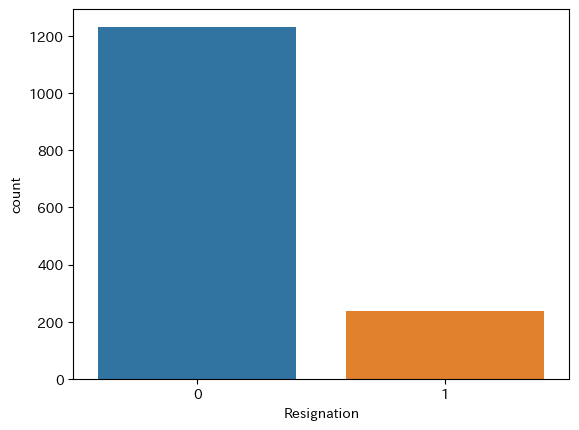

In [39]:
print(feat_df['Resignation'].value_counts())
sns.countplot(data=feat_df, x='Resignation');

## How to deal with this imbalanced dataset?

1. Larger penalty for wrong predictions from the minority class.
2. Upsample the minority class.
3. Generate synthetic training examples.

## Check for Correlation between Department/Position and Resignation Rate

In [47]:
# Group by Department and calculate the resignation count and total count
dept_resignation_df = feat_df.groupby('Department')['Resignation'].value_counts().unstack().reset_index()
dept_resignation_df.columns = ['Department', 'Not Quit', 'Quit']

departments = dept_resignation_df['Department'].unique()
for department in departments:
    current_dept = dept_resignation_df[dept_resignation_df['Department'] == department]
    resignation_percentage = round((current_dept['Quit'] / (current_dept['Not Quit'] + current_dept['Quit']) * 100), 1).values[0]
    print(f"{resignation_percentage}% of employees in {department} resigned")


19.0% of employees in Human Resources resigned
13.8% of employees in Research & Development resigned
20.6% of employees in Sales resigned


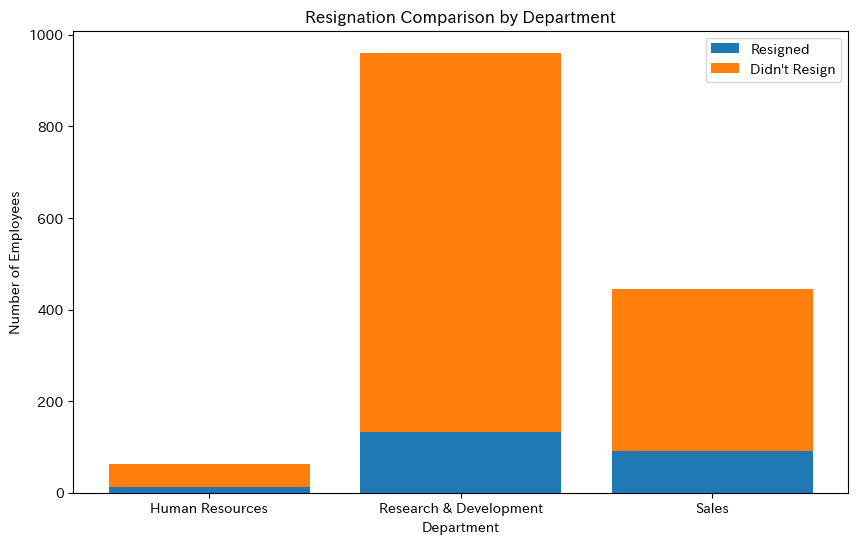

In [49]:
# Visualize the above statistics
plt.figure(figsize=(10, 6))
plt.bar(dept_resignation_df['Department'], dept_resignation_df['Quit'], label='Resigned')
plt.bar(dept_resignation_df['Department'], dept_resignation_df['Not Quit'], bottom=dept_resignation_df['Quit'], label="Didn't Resign")
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.title('Resignation Comparison by Department')
plt.legend()
plt.show()

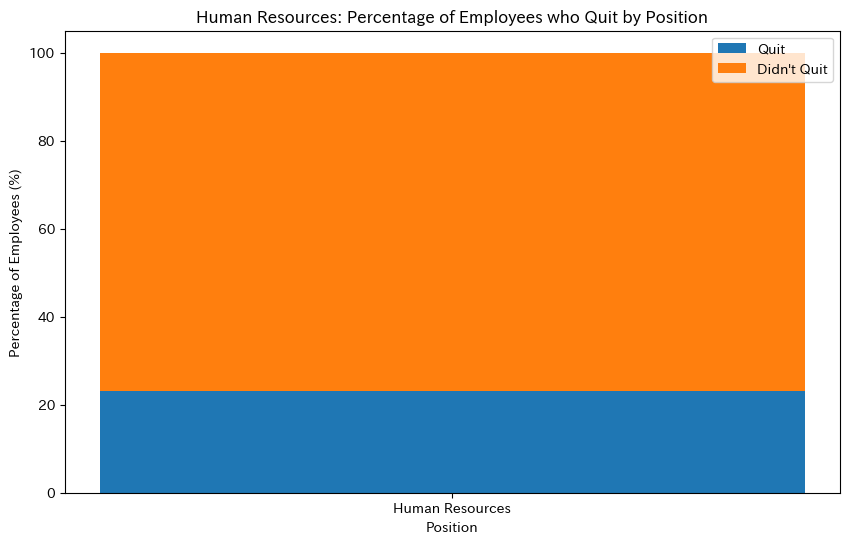

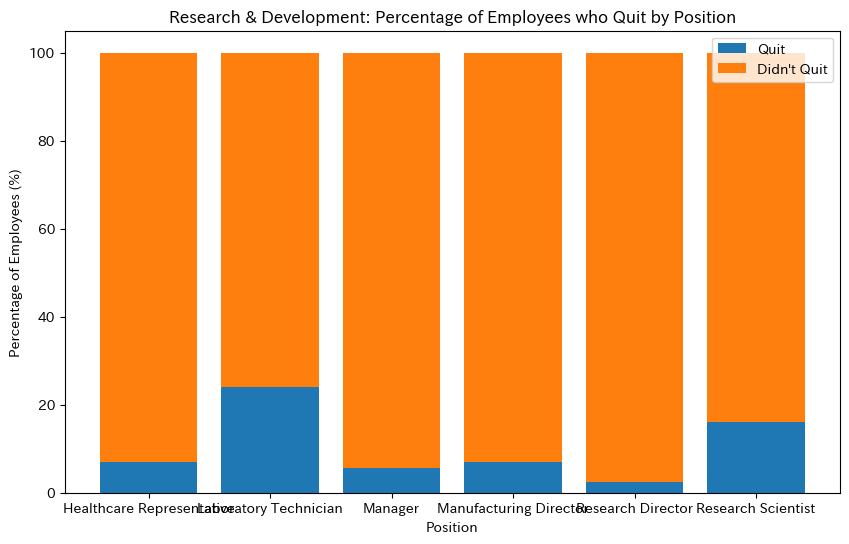

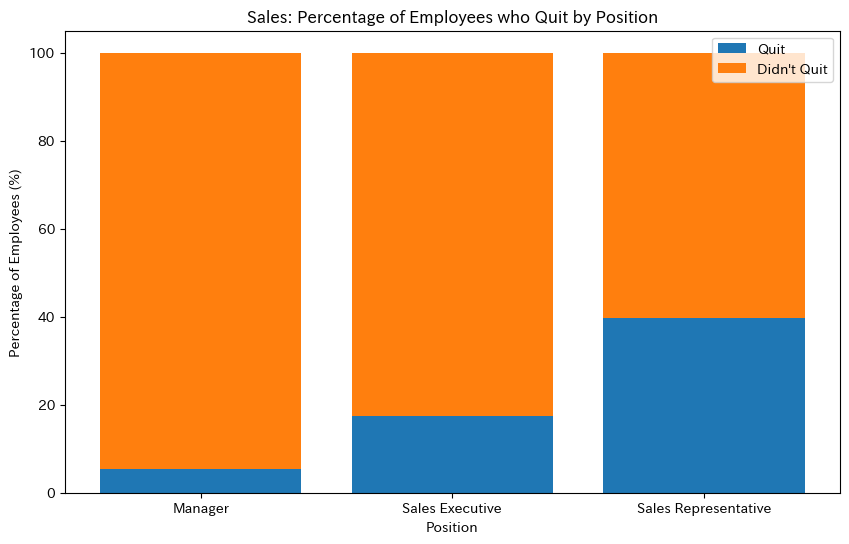

In [41]:
# Group by Department and Position and calculate the resignation percentage and total count
dep_df = feat_df.groupby(['Department', 'Position', 'Resignation'])['Resignation'].count().unstack().reset_index()
dep_df.columns = ['Department', 'Position', 'Not Quit', 'Quit']

# Calculate the percentage of employees who quit and didn't quit in each position
dep_df['QuitPercentage'] = dep_df['Quit'] / (dep_df['Not Quit'] + dep_df['Quit']) * 100
dep_df['NotQuitPercentage'] = dep_df['Not Quit'] / (dep_df['Not Quit'] + dep_df['Quit']) * 100

# Iterate over each department and create a separate graph
departments = dep_df['Department'].unique()

for department in departments:
    data = dep_df[dep_df['Department'] == department]
    
    # Plotting the bar graph for the department
    plt.figure(figsize=(10, 6))
    plt.bar(data['Position'], data['QuitPercentage'], label='Quit')
    plt.bar(data['Position'], data['NotQuitPercentage'], bottom=data['QuitPercentage'], label="Didn't Quit")
    plt.xlabel('Position')
    plt.ylabel('Percentage of Employees (%)')
    plt.title(f'{department}: Percentage of Employees who Quit by Position')
    plt.legend()
    plt.show()



# Model Prep

## Test Train Split

In [54]:
'''Convert dataframe into numpy objects and split them into
train and test sets: 80/20'''

X = feat_df.drop(columns=['Resignation', 'Department', 'Position'])
y = feat_df['Resignation']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

print("Original shape:", X_train.shape, y_train.shape)
y_train.value_counts()

Original shape: (1176, 30) (1176,)


0    986
1    190
Name: Resignation, dtype: int64

## Resampling data

In [56]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
pd.Series(y_train_u).value_counts()

Upsampled shape: (1972, 30) (1972,)


0    986
1    986
dtype: int64

In [61]:
# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Downsampled shape:", X_train_d.shape, y_train_d.shape)
pd.Series(y_train_d).value_counts()

Downsampled shape: (380, 30) (380,)


1    190
0    190
dtype: int64

## Check feature importance with PCA

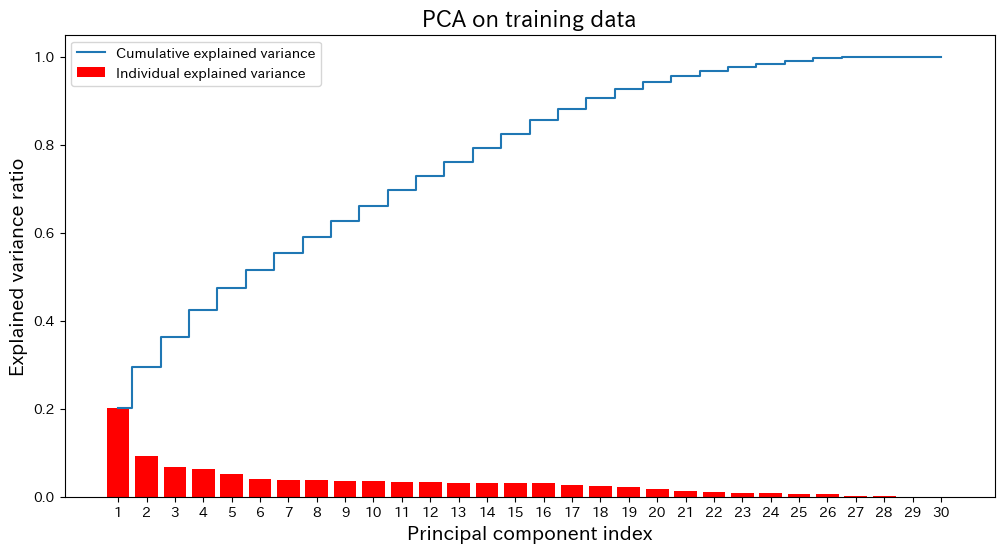

In [60]:
# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 31), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 31), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 31))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

## Find best hyperparams and sample dataset to use

In [64]:
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}
for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print(f"\033[1m\033[0mThe best hyperparameters for {method} data:")
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")

The best hyperparameters for Original data:
criterion :  entropy
max_features :  0.4
min_samples_leaf :  5
n_estimators :  100
Best 10-folds CV f1-score: 46.62%.
The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.55%.
The best hyperparameters for Downsampled data:
criterion :  entropy
max_features :  log2
min_samples_leaf :  1
n_estimators :  50
Best 10-folds CV f1-score: 74.65%.


## Random Forest

In [68]:
# Access the best estimator from the grid search
best_estimator = gs_rf.best_estimator_

# Extract the best parameters from the best estimator
best_params = best_estimator.get_params()

# Create a new pipeline using the best parameters
new_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=best_params['randomforestclassifier__n_estimators'],
        max_features=best_params['randomforestclassifier__max_features'],
        min_samples_leaf=best_params['randomforestclassifier__min_samples_leaf'],
        criterion=best_params['randomforestclassifier__criterion'],
        class_weight="balanced",
        random_state=123
    )
)

/home/jccarville/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


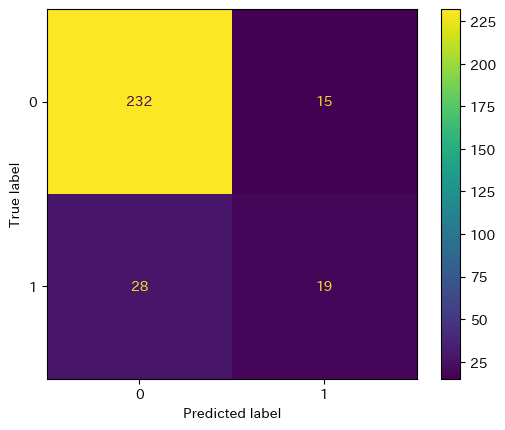

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       247
           1       0.56      0.40      0.47        47

    accuracy                           0.85       294
   macro avg       0.73      0.67      0.69       294
weighted avg       0.84      0.85      0.84       294



In [76]:
# Fit the pipeline on the upsampled training data
new_pipeline.fit(X_train_u, y_train_u)

y_pred = new_pipeline.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show();

print(classification_report(y_test, y_pred))

/home/jccarville/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


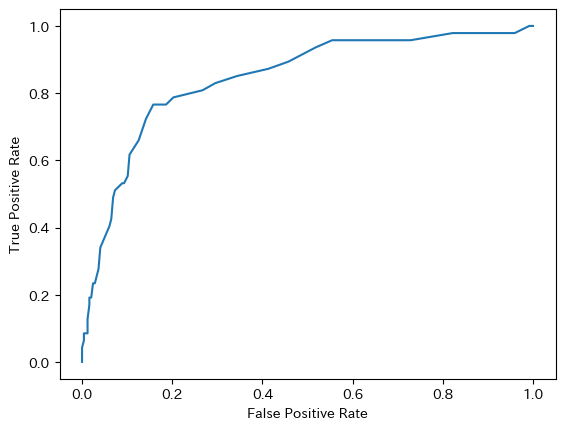

In [77]:
#define metrics
y_pred_proba = new_pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/home/jccarville/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


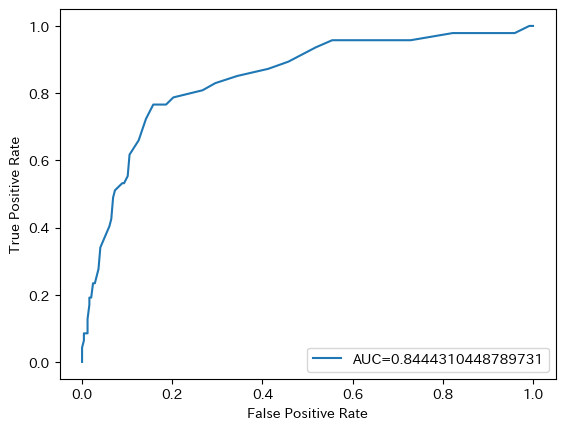

In [80]:
#define metrics
y_pred_proba = new_pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

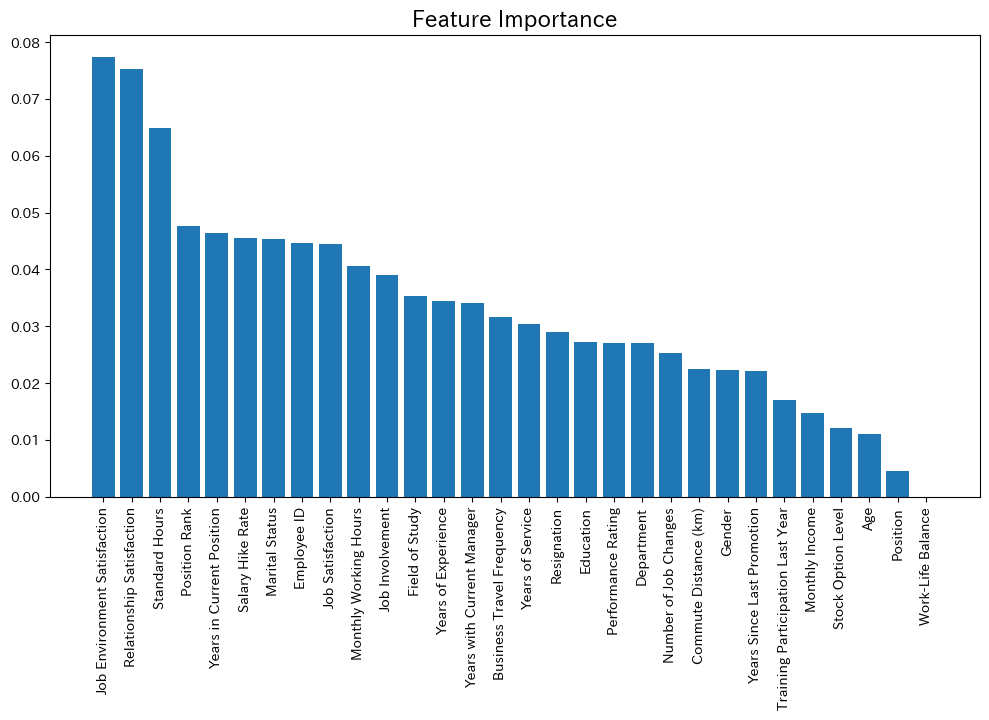

In [83]:
# Refit RF classifier
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_features='log2',
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=123)


clf_rf.fit(StandardScaler().fit_transform(X_train_u), y_train_u)

# Plot features importance
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 31), importances[indices], align="center")
plt.xticks(range(1, 31), df.columns[df.columns != "left"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});